In [21]:
import numpy as np
import pandas as pd
import math
import re
# import emoji
from nltk.corpus import stopwords
import seaborn as sns
# from nltk.stem import WordNetLemmatizer, PorterStemmer
# from nltk.tokenize import word_tokenize
import unidecode
from sklearn.utils import resample
import warnings
from sklearn.model_selection import train_test_split
from sklearn.metrics import plot_confusion_matrix, f1_score, accuracy_score, precision_score, recall_score
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.naive_bayes import BernoulliNB
from sklearn.multiclass import OneVsRestClassifier
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')

In [10]:
df_2022 = pd.read_csv('../data/tweet_data_2022.csv')
df_2023 = pd.read_csv('../data/tweet_data_2023.csv')

### Three types of Sampling Strategies
- Committee-based Strategies
    -  Build several models and use the models’ prediction to determine the most informative data. The data is considered as most informative if there is maximum disagreement in predictions from the models. The disagreement can be measured by entropy or KL-Divergence
        - Query by Committee (QBC)
        - Entropy-based Query by Bagging (EQB)
        - Adaptive Maximum Disagreement (AMD)


- Large margin-based Strategies
    - Specifically for margin-based classifiers such as SVM. The distance to the separating hyperplane can be viewed as a good metric to measure the model’s confidence or certainty on unlabeled data samples. In SVM, the support vectors which define the decision boundary would be the most informative data samples.
        - Margin Sampling (MS)
        - Multiclass Level Uncertainty (MCLU)
        - Margin Sampling-closest Support Vectors (MS-cSV)
        
- Posterior probability-based Strategies
    - Based on the estimation of class membership probabilities. The posterior probability distribution is used to determine whether the unlabeled data sample should be queried for label or not. This strategy can be used with any type of model which has the ability to predict output probabilities for class membership. The posterior probability distribution gives an idea about the model’s confidence and certainty in the assignment of a particular class to the data sample.
        - Least Confidence (LC)
        - Best-versus-Second-Best (BvSB) or Smallest Margin
        - Entropy

- **Yunyi** will explore **Query by Committee (QBC)** and **Entropy-based Query by Bagging (EQB)**


- **Tony** will explore Posterior probability-based Startegies including **least confidence** and **Entropy**

From the previous quarter, the best model for relevance prediction is **Naive Bayes** and the best model for sentiment prediction is **Random Forest**. Because neither Naive Bayes nor Random Forest belongs to margin-based models, we will not explore large margin-based startegies in the project. 

### Active Learning Pipeline Procedures

**1. Balance and partition the dataset**
- Shuffle the dataset and separate the data based on the label (Group 1 vs. Group 2 or 3)
- For each group of data:
    - Seed: Used for training the model, 60% of the dataset
    - Unlabeled: Used for active learning, 20% of the dataset
    - Test: Used for testing the changes of model result before and after the active learning, 20% of the dataset
- Combine the groups of data

**2. Train the model using Seed data and cross-validation**
- Train the Bernoulli Naive Bayes Model using the Seed data
- Apply cross-validation to find the most consistant model parameters

**3. Choose unlabeled instances**
- Using Pool-based sampling, choose the round of iterations and the number of instances to add to the training set
- For each iteration, 
    - select X instances from the unlabeled data using the sampling strategies
    - add the instances to the training set
    
**4. Stopping criteria**
- \# of instances queried
- \# of iterations of steps 2 and 3
- After the performance doesn't imporve significantly

**5. Compare the model performances on Test set**
- Report the accuracy of the model that uses only Seed data as the training set
- Report the accuracy of the model after using active learning

### Data Preprocessing

In [11]:
def standardize_bucket(bucket):
    if ((bucket == '1.0') | (bucket == '1')):
        return '1'
    elif ((bucket == '2') | (bucket == '3') | (bucket == '2.0') | (bucket == '3.0')):
        return '2 or 3'
    else:
        return bucket

In [12]:
def clean_text(text):
    if type(text) == np.float:
        return ""
    temp = text.lower() # to lower case
    temp = re.sub("'", "", temp) # to avoid removing contractions in english
    temp = re.sub("@[A-Za-z0-9_]+","", temp) # remove @s
    temp = re.sub("#[A-Za-z0-9_]+","", temp) # remove hashtags
    temp = re.sub(r'http\S+', '', temp) # remove links
    temp = re.sub(r"www.\S+", "", temp) # remove links
    temp = re.sub(r'\n|[^a-zA-Z]', ' ', temp) # remove punctuation
    temp = temp.replace("\n", " ").split()
    temp = [w for w in temp if not w in stopwords_] # remove stopwords
    temp = [w for w in temp if not w.isdigit()] # remove numbers
    temp = [unidecode.unidecode(w) for w in temp] # turn non-enlish letters to english letters
    temp = " ".join(word for word in temp)
    return temp

In [13]:
original_stopwords = stopwords.words('english')
additional_stopwords = ['none']
original_stopwords.extend(additional_stopwords)
stopwords_ = set(original_stopwords)

#Selects only the tweets about China
df = df_2022[df_2022['country']=='China']
df = df[['text', 'id', 'Bucket', 'SentimentScore']]
#Shuffle the data
df = df.sample(frac=1, replace=False, random_state=1) 
df.reset_index(drop=True, inplace=True)
#Standardized the bucket label
df['Bucket'] = df['Bucket'].apply(standardize_bucket)
#Remove tweets that are in both buckets
df_bucket_count = pd.DataFrame(df.groupby('id')['Bucket'].nunique())
df_bucket_count.reset_index(inplace=True)
df_bucket_count.columns = ['tweet_id', 'bucket_num']
df = df.merge(df_bucket_count, left_on='id', right_on='tweet_id')
df = df[df['bucket_num'] == 1]
#Remove tweets without a bucket (null)
df = df[(df['Bucket'] == '1') | (df['Bucket'] == '2 or 3')]
#Remove duplicates
df = df.drop_duplicates(subset=['id']).reset_index(drop=True)
df = df[['text', 'Bucket']]
df["text_cleaned"] = [clean_text(t) for t in df["text"]]

### 1. Balance and Partition the dataset (Group 1 vs. Group 2 or 3; Seed, Unlabeled, Test)

In [14]:
df_1 = df[df.Bucket=='1']
df_2_3 = df[df.Bucket=='2 or 3']
sample_size = min(df[df.Bucket=='1'].shape[0], df[df.Bucket=='2 or 3'].shape[0])

In [15]:
def partition_data(df):
    #partiton
    df_rows = df.shape[0]
    seed_num = math.floor(df_rows * 0.8)
    seed = df[:seed_num]
    unlabelled_num = seed_num + (math.floor(df_rows * 0.1))
    unlabelled = df[seed_num:unlabelled_num]
    test = df[unlabelled_num:]
    return seed, unlabelled, test

In [16]:
seed_1, unlabeled_1, test_1 = partition_data(df_1)
seed_2_3, unlabeled_2_3, test_2_3 = partition_data(df_2_3)
seed = pd.concat([seed_1, seed_2_3])
unlabeled = pd.concat([unlabeled_1, unlabeled_2_3])
test = pd.concat([test_1, test_2_3])
print(seed.shape)
print(unlabeled.shape)
print(test.shape)

(8117, 3)
(1014, 3)
(1016, 3)


In [17]:
seed_1 = seed[seed.Bucket=='1']
seed_2_3 = seed[seed.Bucket=='2 or 3']
sample_size = min(seed_1.shape[0], seed_2_3.shape[0])
seed_1_b = resample(seed_1, replace=False, n_samples=sample_size, random_state=123)
seed_2_3_b = resample(seed_2_3, replace=False, n_samples=sample_size, random_state=123)
seed = pd.concat([seed_1_b, seed_2_3_b])

In [18]:
seed.Bucket.value_counts()

1         1649
2 or 3    1649
Name: Bucket, dtype: int64

### 2. Train the model using Seed data and cross-validation

In [19]:
categories = ['Bucket']
train, test = train_test_split(seed, random_state=42, test_size=0.2, shuffle=True)
X_train, X_test, Y_train, Y_test = train[['text_cleaned']], test[['text_cleaned']], train[['Bucket']], test[['Bucket']]
print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)

(2638, 1)
(660, 1)
(2638, 1)
(660, 1)


In [23]:
random_state_value = 2
round_number = 4

#Wrap in ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ("tf", CountVectorizer(stop_words=stopwords_), 'text_cleaned'),
        ("tfidf", TfidfVectorizer(stop_words=stopwords_), 'text_cleaned')]
)

In [24]:
#Define the model
model = BernoulliNB(fit_prior=True, class_prior=None)
model_name = 'Bernoulli Naive Bayes'

In [25]:
#Build the pipeline
pipeline = Pipeline([
            ('preprocessor', preprocessor),
            ('clf', OneVsRestClassifier(model, n_jobs=1)),
        ])

In [32]:
#Train the model
pipeline.fit(X_train, Y_train)

# compute the testing accuracy
prediction = pipeline.predict(pd.DataFrame(X_test))
print('The model name is ' + model_name + '.')
print('Test accuracy is {}'.format(round(accuracy_score(Y_test, prediction), round_number)))

The model name is Bernoulli Naive Bayes.
Test accuracy is 0.7864


F1 score is 0.7867
Precision score is 0.8553
Recall score is 0.7283


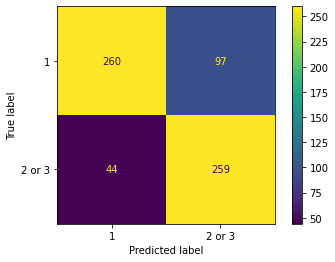

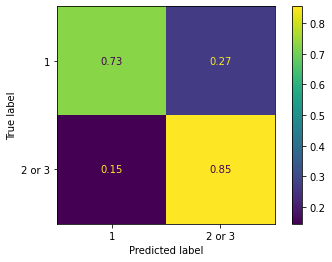

In [33]:
# compute the f1 score
f1 = round(f1_score(np.array(Y_test), prediction, pos_label='1'), round_number)
print('F1 score is {}'.format(f1))
# compute the precision score
precision = round(precision_score(np.array(Y_test), prediction, pos_label='1', average='binary'), round_number)
print('Precision score is {}'.format(precision))
# compute the precision score
recall = round(recall_score(np.array(Y_test), prediction, pos_label='1', average='binary'), round_number)
print('Recall score is {}'.format(recall))
plot_confusion_matrix(pipeline, X_test, Y_test)
plt.show()
plot_confusion_matrix(pipeline, X_test, Y_test, normalize='true')
plt.show()

## 3. Choose unlabeled instances

#### Least Confidence

- Select the unlabeled data samples for which the model is least confident in prediction or class assignment. 
- These data samples improve the model’s discriminative ability. 50%-50% > 90%-10%


In [117]:
#number of iterations
iteration = 20

#number of instances to add to the seed data in one iteration
instances = 10

unlabeled_x = unlabeled[['text_cleaned']]
unlabeled_y = unlabeled[['Bucket']]
prob = pipeline.predict_proba(unlabeled_x)
unlabeled['prob'] = list(prob)
unlabeled['lc'] = np.abs(np.diff(prob)).flatten()

In [130]:
unlabeled.sort_values(by=['lc'], ascending=True, inplace=True)

In [133]:

info_data = unlabeled.iloc[:instances]
unlabeled = unlabeled.iloc[instances:]

,text,Bucket,text_cleaned,lc,prob
8592,Trump has accomplished more on N Korea to date...,1,trump accomplished n korea date us president c...,0.025438,"[0.5127190366757652, 0.4872809633242348]"
8195,Is the Biden administration denying the realit...,1,biden administration denying reality china ong...,0.030828,"[0.48458600369673477, 0.5154139963032652]"
8166,I join my @China_TaskForce colleagues in comme...,2 or 3,join colleagues commending biden formation dep...,0.061375,"[0.4693126856782418, 0.5306873143217582]"
8679,Chinese authorities are hunting down protester...,1,chinese authorities hunting protesters inner m...,0.065898,"[0.5329490501536329, 0.4670509498463671]"
8664,I agree with Attorney General Barr:\n\nThe mos...,1,agree attorney general barr aggressive threat ...,0.077333,"[0.5386662690176907, 0.4613337309823093]"
9071,"If we fail to stand up for steel jobs today, C...",1,fail stand steel jobs today china come jobs su...,0.104992,"[0.552496048456621, 0.44750395154337896]"
8668,TODAY: Join a group of esteemed panelists and ...,1,today join group esteemed panelists today pm d...,0.105665,"[0.4471675319662072, 0.5528324680337928]"
8627,I called upon @SecPompeo to answer questions o...,1,called upon answer questions u efforts address...,0.111915,"[0.5559575150394708, 0.4440424849605292]"
8540,.@SenatorCarper and I learned that schools in ...,1,learned schools united states kindergarten col...,0.112690,"[0.5563450534729565, 0.4436549465270435]"
8530,Why has @SpeakerPelosi done nothing about the ...,1,done nothing propaganda litters halls congress...,0.119664,"[0.4401680463887535, 0.5598319536112465]"


<AxesSubplot:xlabel='lc', ylabel='Density'>

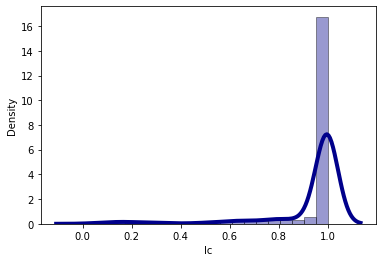

In [129]:
sns.distplot(unlabeled['lc'], hist=True, kde=True, 
             bins=int(20), color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})

,text,Bucket,text_cleaned,lc,prob
8592,Trump has accomplished more on N Korea to date...,1,trump accomplished n korea date us president c...,0.025438,NaN
8195,Is the Biden administration denying the realit...,1,biden administration denying reality china ong...,0.030828,NaN
8166,I join my @China_TaskForce colleagues in comme...,2 or 3,join colleagues commending biden formation dep...,0.061375,NaN
8679,Chinese authorities are hunting down protester...,1,chinese authorities hunting protesters inner m...,0.065898,NaN
8664,I agree with Attorney General Barr:\n\nThe mos...,1,agree attorney general barr aggressive threat ...,0.077333,NaN
...,...,...,...,...,...
8608,Universities throughout #Ohio are on the cutti...,1,universities throughout cutting edge innovatio...,1.000000,NaN
8938,The President needs to have a clear and consis...,1,president needs clear consistent approach chin...,1.000000,NaN
8614,The Chinese Communist Party actively engaged i...,1,chinese communist party actively engaged cover...,1.000000,NaN
8920,Proud to co-sponsor this important legislation...,1,proud co sponsor important legislation would h...,1.000000,NaN


In [88]:
pd.Series(list(prob))

0        [0.9999667583047778, 3.324169522227354e-05]
1                       [1.0, 1.126790769132397e-17]
2         [0.999999645553605, 3.544463950429719e-07]
3        [0.999999982722623, 1.7277377019064615e-08]
4        [1.197127113217178e-06, 0.9999988028728868]
                            ...                     
1009     [5.548468931637629e-06, 0.9999944515310684]
1010     [2.3590018827235326e-12, 0.999999999997641]
1011     [3.633623123544538e-05, 0.9999636637687646]
1012    [0.00015082292482426762, 0.9998491770751757]
1013     [1.5408540950945238e-05, 0.999984591459049]
Length: 1014, dtype: object

#### Best-versus-Second-Best (BvSB)

- Find the two most probable classes (the classes having the highest and second-highest probabilities), then minimize the difference of probabilities between them.
- 0.8 - 0.1 = 0.7; 0.5 - 0.4 = 0.1; 0.7 > 0.1 so (0.5, 0.4 is more uncertain)


Since we only have two classes here, therefore, we will not explore Best-versus-Second-Best strategy

#### Entropy

- For classification with a large number of classes, above two posterior probability-based strategies do not fit to be optimal because they consider one or two most probable classes for sampling. The information lying in the remaining classes’ probability distribution is unused. To address this issue, the entropy measure is designed for sampling.
- Maximize the entropy will give us the data sample which the model is least certain about the class assignment.


**Binary Cross Entropy** is the negative average of the log of corrected predicted probabilities.

https://www.analyticsvidhya.com/blog/2021/03/binary-cross-entropy-log-loss-for-binary-classification/

#### Sentiment Prediction

In [ ]:
from scipy.stats import entropy
base = 2  # work in units of bits
pk = np.array([2/4, 2/4])  # fair coin
H = entropy(pk, base=base)
H